In [31]:
import pandas as pd
import numpy as np
df = pd.read_csv('Data_Entry_2017_v2020.csv', usecols=['Image Index', 'Patient ID', 'View Position', 'Finding Labels'])
print(len(df))

112120


In [ ]:
df.head()

In [33]:
labels = df["Finding Labels"].str.get_dummies(sep="|").astype(np.float32)
df = pd.concat([df, labels], axis=1)
df.drop(columns=["Finding Labels"], inplace=True)

In [34]:
common_diseases = [
    "Atelectasis",
    "Cardiomegaly",
    "Consolidation",
    "Edema",
    "Effusion",
    "No Finding",
    "Pneumonia",
    "Pneumothorax"
]
# go through the dataframe and drop rows where there are no 1s for any common diseases 
df_2 = df.loc[(df[common_diseases] != 0).any(axis=1)]
cnt = df.shape[0] - df.loc[(df[common_diseases] != 0).any(axis=1)].shape[0]
print(f"Dropped {cnt} rows from the dataset. {df_2.shape[0]} rows remaining.")  

Dropped 20343 rows from the dataset. 91777 rows remaining.


In [35]:
# drop any column past 3 whose name is not in common_diseases
df_2 = df_2.drop(columns=df_2.columns[3:][~df_2.columns[3:].isin(common_diseases)])

In [36]:
diseases = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Pneumonia', 'Pneumothorax']
assert (df_2[(df_2[diseases] == 0).all(axis=1)]["No Finding"] == 1).all()

In [40]:
# find duplicate rows, which are those where the Patientid, the projection and the labels are the same
# mark the last duplicates and remove them
cnt_before = len(df_2)
# # print a few duplicates to confirm
# df_2[df_2.duplicated(subset=["Patient ID", "View Position"]+common_diseases, keep=False)].head()
df_2.drop_duplicates(subset=["Patient ID", "View Position"]+common_diseases, keep="first", inplace=True)
# count the duplicates
print(f"Dropped {cnt_before - len(df_2)} duplicates. {len(df_2)} rows remaining in the training dataset.")

Dropped 43075 duplicates. 48702 rows remaining in the training dataset.


<Axes: title={'center': 'Label distribution CXR14'}>

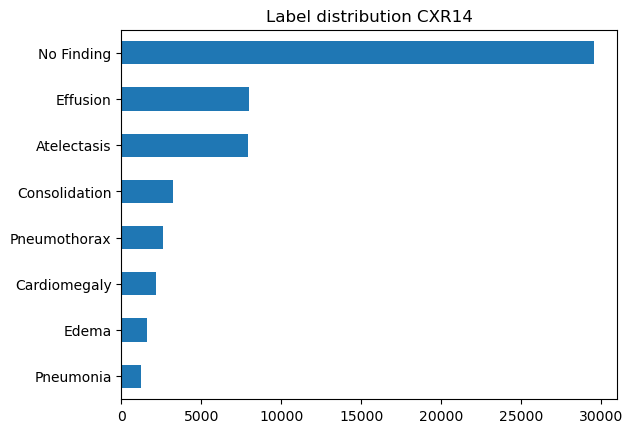

In [41]:
# label distribution
label_distribution = df_2[common_diseases].sum()
# plot as a horizontal bar chart, sorted
label_distribution.sort_values().plot(kind="barh", title="Label distribution CXR14")

In [42]:
# save the dataframe to a new csv file 
df_2.to_csv("cxr14_processed.csv", index=False)

In [43]:
# Now let's preprocess the images to 224x224 and CLAHE and save them to a new folder
import cv2
import os
from tqdm import tqdm

# create a new folder to save the images
if not os.path.exists("images_224"):
    os.makedirs("images_224")

# iterate through the rows of the dataframe
df_pre = pd.read_csv("cxr14_processed.csv")
for index, row in tqdm(df_pre.iterrows(), total=len(df_pre)):
    # get the image id
    image_id = row["Image Index"]
    # read the image
    img = cv2.imread(f"images/{image_id}", cv2.IMREAD_GRAYSCALE)
    # crop 5% of the image from all sides to remove blown borders and artifacts
    img = img[int(img.shape[0]*0.05):int(img.shape[0]*0.95), int(img.shape[1]*0.05):int(img.shape[1]*0.95)]
    # resize the image to 224x224
    img = cv2.resize(img, (224, 224))
    # # apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    # apply histogram equalization
    # img = cv2.equalizeHist(img)
    # save the image
    cv2.imwrite(f"images_224/{image_id}", img)

100%|██████████| 48702/48702 [41:52<00:00, 19.38it/s]  


In [44]:
# verify they are all valid image files
for index, row in tqdm(df_pre.iterrows(), total=len(df_pre)):
    image_id = row["Image Index"]
    img = cv2.imread(f"images_224/{image_id}", cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"{image_id} is not a valid image")
        break

100%|██████████| 48702/48702 [09:08<00:00, 88.78it/s] 


In [47]:
# rename Image Index to Path
df_pre.rename(columns={"Image Index": "Path"}, inplace=True)
df_pre.to_csv("cxr14_processed.csv", index=False)

In [58]:
# keep 10k images for testing
# find unique patients
unique_patients = df_pre["Patient ID"].unique()
# shuffle the patients
np.random.seed(42)
np.random.shuffle(unique_patients)
# check how many images the first 5711 patients have
print(df_pre[df_pre["Patient ID"].isin(unique_patients[:5711])].shape[0])

# make them the test set
df_test = df_pre[df_pre["Patient ID"].isin(unique_patients[:5711])]
df_train_val = df_pre[~df_pre["Patient ID"].isin(unique_patients[:5711])]

# save the test set
df_test.to_csv("cxr14_test.csv", index=False)

print(len(df_train_val), len(df_test))

10000
38702 10000


<Axes: title={'center': 'Label distribution CXR14 training and validation set'}>

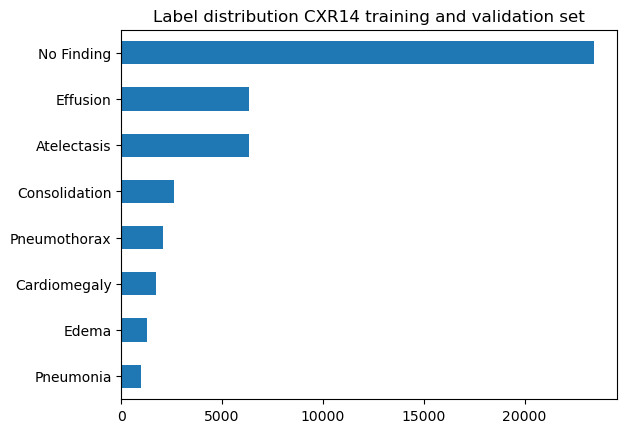

In [59]:
# plot the label distribution of the training and validation set
label_distribution = df_train_val[common_diseases].sum()
label_distribution.sort_values().plot(kind="barh", title="Label distribution CXR14 training and validation set")

In [69]:
# keep 15k images for validation
# find unique patients
unique_patients = df_train_val["Patient ID"].unique()
# shuffle the patients
np.random.seed(42)
np.random.shuffle(unique_patients)
# check how many images the first 8470 patients have
print(df_train_val[df_train_val["Patient ID"].isin(unique_patients[:8470])].shape[0])

15000


In [70]:
# split the training and the validation set
df_val = df_train_val[df_train_val["Patient ID"].isin(unique_patients[:8470])]
df_train = df_train_val[~df_train_val["Patient ID"].isin(unique_patients[:8470])]
# save the training and validation set
df_val.to_csv("cxr14_val.csv", index=False)
df_train.to_csv("cxr14_train.csv", index=False)

In [71]:
len(df_train), len(df_val), len(df_test)

(23702, 15000, 10000)

In [72]:
df_train

,Path,Patient ID,View Position,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,No Finding,Pneumonia,Pneumothorax
2,00000002_000.png,2,PA,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,00000005_000.png,5,PA,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,00000005_001.png,5,AP,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,00000005_007.png,5,PA,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,00000008_000.png,8,PA,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
48692,00030797_000.png,30797,PA,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
48693,00030798_000.png,30798,PA,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
48695,00030800_000.png,30800,PA,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
48698,00030802_000.png,30802,PA,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
